# IND320 CA1 Ivar Eftedal

### Use of AI
- For compulsary assignment 2 i used AI more than i did in the first assignemnt. I mostly used AI for helping me with debugging as well as making the plots in both the streamlit and the jupiter notebook. I also had a bunch of problems with using jupiter notebook vscode stopped working. I was able to get pycharm to run the jupiter notebooks. For all the AI usage i used the free version og ChatGPT. I also got nice help from AI to resolve a bunch of the time related code. Both the problem of time change between summer and winter, and of how to properly parse the time to make the date work properly.

### Log of compulsary work
- Personally i feel like this assignment was fun, but it took a long time to get all of the dependencies up and running. I had some issues getting things to work together, but think i found some neet solutions in the end. The book for the course definately helped. I especially had problems with the java language and getting the right python version. Combining this with getting it to work with the kernel i the jupiter notebook is what took the most amount of time for this assignment. I was able to fix this using nix and uv as packet managers. I use nix for installing python 3.12 as well as java. I also used nix to install the uv and the needed dependencies for using jupiter notebook. I then used uv for all the python packages needed. It is like using requirements.py but you get the lock the package versions to make sure they work together. Using this setup i got full control over every dependency and package in the project. I also found out that using nix with uv makes the setup reproducible on any machine. Which means if i have to wipe my PC again i can jump right back in as long as i remember to push the code to github.
- I also found a helpful app called "Tableplus" that lets one connect to the locally hosted database and inspect the entries in the diffrent tables of the database. This might be helpful to others as well as a way to double check that things are actually getting added to cassandra.
- I think it was cool fetch data from an api and add the data to a locally hosted database as well as mongodb.


### Experience with jupiter notebook and streamlit
- I must also say that i am still somewhat frustrated having to work with jupiter notebooks, but i think i have finally found a setup that works fairly well, which should make it simpler for the next assignment. Streamlit was still nice to work with.

### Links:
- [GitHub](https://github.com/ioeftedal/ind320ioeftedal)
- https://github.com/ioeftedal/ind320ioeftedal
- [Streamlit](https://ind320ioeftedal.streamlit.app)
- https://ind320ioeftedal.streamlit.app

## Getting into the code:

### Import dependencies

In [37]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import MongoClient
from pyspark.sql import SparkSession
from cassandra.cluster import Cluster
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, TimestampType, IntegerType
from pyspark.sql import functions as F

### Ensure cassandra connector is loaded

In [13]:
os.environ["PYSPARK_SUBMIT_ARGS"] = (
    "--packages com.datastax.spark:spark-cassandra-connector_2.12:3.5.1 pyspark-shell"
)

# Defining some essential constansts
BASE_URL = "https://api.elhub.no/energy-data/v0/price-areas"
YEAR = 2021
KEYSPACE = "elhub_data"
TABLE = f"consumption_{YEAR}"

### Connect to cassandra

In [14]:
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()

# Create keyspace if it does not exist
session.execute(f"""
CREATE KEYSPACE IF NOT EXISTS {KEYSPACE}
WITH REPLICATION = {{ 'class': 'SimpleStrategy', 'replication_factor': 1 }};
""")

session.set_keyspace(KEYSPACE)

# Drop and recreate table so that i dont get too much data in the database while developing
session.execute(f"DROP TABLE IF EXISTS {TABLE};")

# Creating the structure of how the database should look
session.execute(f"""
CREATE TABLE IF NOT EXISTS {TABLE} (
    priceArea text,
    consumptionGroup text,
    quantityKwh double,
    startTime timestamp,
    endTime timestamp,
    meteringPointCount int,
    lastUpdatedTime timestamp,
    PRIMARY KEY ((priceArea, consumptionGroup), startTime)
);
""")

### Fetch data from API

In [18]:
# Creating an empty list that will store the data for each entry
records = []

# Loop over all months of the year
for month in range(1, 13):
    start = f"{YEAR}-{month:02d}-01"
    end = f"{YEAR + 1}-01-01" if month == 12 else f"{YEAR}-{month + 1:02d}-01"
    url = f"{BASE_URL}?startDate={start}&endDate={end}&dataset=CONSUMPTION_PER_GROUP_MBA_HOUR"

    print(f"Fetching data for {start} until {end}")

    # Save the request as json format
    response = requests.get(url).json()

    for item in response.get("data", []):
        attributes = item.get("attributes", {})
        consumption_list = attributes.get("consumptionPerGroupMbaHour", [])

        if isinstance(consumption_list, list):
            for column in consumption_list:
                records.append({
                    "priceArea": column.get("priceArea"),
                    "consumptionGroup": column.get("consumptionGroup"),
                    "quantityKwh": column.get("quantityKwh"),
                    "startTime": column.get("startTime"),
                    "endTime": column.get("endTime"),
                    "meteringPointCount": column.get("meteringPointCount"),
                    "lastUpdatedTime": column.get("lastUpdatedTime"),
                })

print(f"Finished fetching. Total records: {len(records)}")

Fetching data for 2021-01-01 until 2021-02-01
Fetching data for 2021-02-01 until 2021-03-01
Fetching data for 2021-03-01 until 2021-04-01
Fetching data for 2021-04-01 until 2021-05-01
Fetching data for 2021-05-01 until 2021-06-01
Fetching data for 2021-06-01 until 2021-07-01
Fetching data for 2021-07-01 until 2021-08-01
Fetching data for 2021-08-01 until 2021-09-01
Fetching data for 2021-09-01 until 2021-10-01
Fetching data for 2021-10-01 until 2021-11-01
Fetching data for 2021-11-01 until 2021-12-01
Fetching data for 2021-12-01 until 2022-01-01
Finished fetching. Total records: 219000


### Convert to spark dataframe

In [19]:
# Define schema for the data that will be inserted into the database
schema = StructType([
    StructField("priceArea", StringType(), True),
    StructField("consumptionGroup", StringType(), True),
    StructField("quantityKwh", DoubleType(), True),
    StructField("startTime", TimestampType(), True),
    StructField("endTime", TimestampType(), True),
    StructField("meteringPointCount", IntegerType(), True),
    StructField("lastUpdatedTime", TimestampType(), True),
])

# Convert to pandas and make sure to take the summertimes and wintertimes into account (utc=true)
pandas_df = pd.DataFrame(records)
pandas_df["startTime"] = pd.to_datetime(pandas_df["startTime"], utc=True)
pandas_df["endTime"] = pd.to_datetime(pandas_df["endTime"], utc=True)
pandas_df["lastUpdatedTime"] = pd.to_datetime(pandas_df["lastUpdatedTime"], utc=True)

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("SparkCassandraApp") \
    .config("spark.cassandra.connection.host", "localhost") \
    .config("spark.cassandra.connection.port", "9042") \
    .config("spark.sql.extensions", "com.datastax.spark.connector.CassandraSparkExtensions") \
    .config("spark.sql.catalog.mycatalog", "com.datastax.spark.connector.datasource.CassandraCatalog") \
    .getOrCreate()

# Create a spark dataframe that follows the schema that was created
spark_df = spark.createDataFrame(pandas_df, schema=schema)

# Rename column names to lowercase so that it works with cassandra since it is case sensitive
spark_df = (
    spark_df
    .withColumnRenamed("priceArea", "pricearea")
    .withColumnRenamed("consumptionGroup", "consumptiongroup")
    .withColumnRenamed("startTime", "starttime")
    .withColumnRenamed("endTime", "endtime")
    .withColumnRenamed("meteringPointCount", "meteringpointcount")
    .withColumnRenamed("lastUpdatedTime", "lastupdatedtime")
    .withColumnRenamed("quantityKwh", "quantitykwh")
)

### Write to cassandra

In [20]:
spark_df.write \
    .format("org.apache.spark.sql.cassandra") \
    .mode("append") \
    .option("keyspace", KEYSPACE) \
    .option("table", TABLE) \
    .save()

25/10/24 16:01:26 WARN TaskSetManager: Stage 33 contains a task of very large size (1019 KiB). The maximum recommended task size is 1000 KiB.


### Verify that it worked by reading from the cassandra database

In [21]:
spark.read \
    .format("org.apache.spark.sql.cassandra") \
    .option("keyspace", KEYSPACE) \
    .option("table", TABLE) \
    .load() \
    .show(5)

+---------+----------------+-------------------+-------------------+-------------------+------------------+-----------+
|pricearea|consumptiongroup|          starttime|            endtime|    lastupdatedtime|meteringpointcount|quantitykwh|
+---------+----------------+-------------------+-------------------+-------------------+------------------+-----------+
|      NO1|       secondary|2021-01-01 00:00:00|2021-01-01 01:00:00|2024-12-20 10:35:40|             20866|  693011.75|
|      NO1|       secondary|2021-01-01 01:00:00|2021-01-01 02:00:00|2024-12-20 10:35:40|             20866|   684410.2|
|      NO1|       secondary|2021-01-01 02:00:00|2021-01-01 03:00:00|2024-12-20 10:35:40|             20866|   683669.2|
|      NO1|       secondary|2021-01-01 03:00:00|2021-01-01 04:00:00|2024-12-20 10:35:40|             20866|   678126.0|
|      NO1|       secondary|2021-01-01 04:00:00|2021-01-01 05:00:00|2024-12-20 10:35:40|             20866|   678471.8|
+---------+----------------+------------

## Creating Plots

### Pie Chart

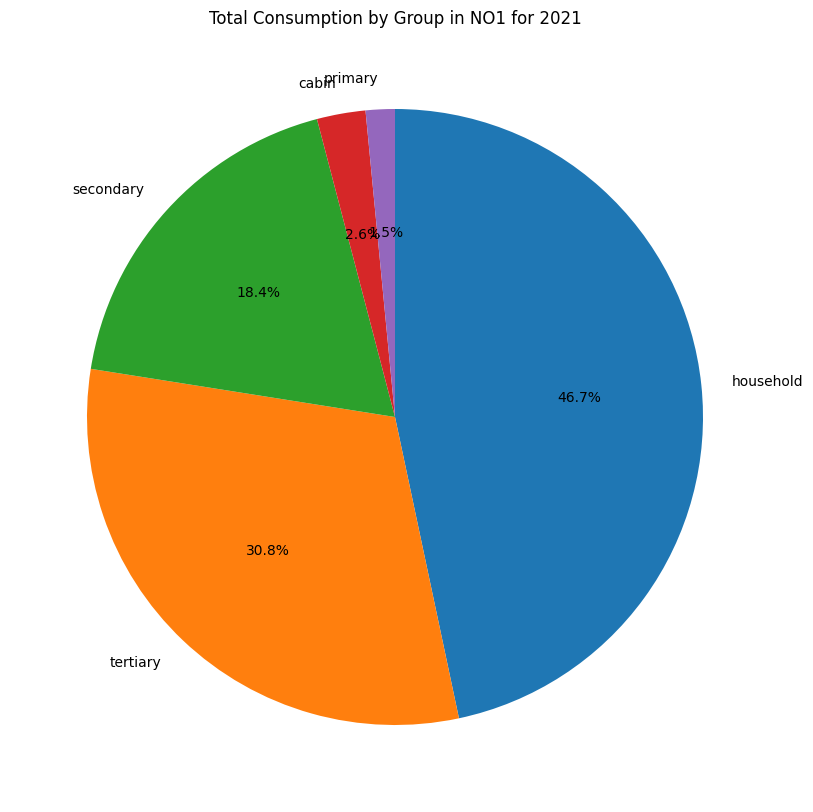

In [33]:
# Read data from cassandra
TABLE = f"consumption_{YEAR}"

# Save the nedded columns to a new dataframe
df = (
    spark.read
    .format("org.apache.spark.sql.cassandra")
    .option("keyspace", KEYSPACE)
    .option("table", TABLE)
    .load()
    .select("pricearea", "consumptiongroup", "starttime", "quantitykwh")
)

# Aggregate total yearly consumption by group
summary_df = (
    df.filter(F.col("pricearea") == "NO1")
      .groupBy("consumptiongroup")
      .agg(F.sum("quantitykwh").alias("total_quantitykwh"))
      .orderBy(F.desc("total_quantitykwh"))
)

# Convert to pandas and create pie chart
summary_pd = summary_df.toPandas()

# Plot the pandas dataframe
plt.figure(figsize=(10, 10))
plt.pie(
    summary_pd["total_quantitykwh"],
    labels=summary_pd["consumptiongroup"],
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False
)
plt.title(f"Total Consumption by Group in NO1 for {YEAR}")
plt.show()


### Line Plot

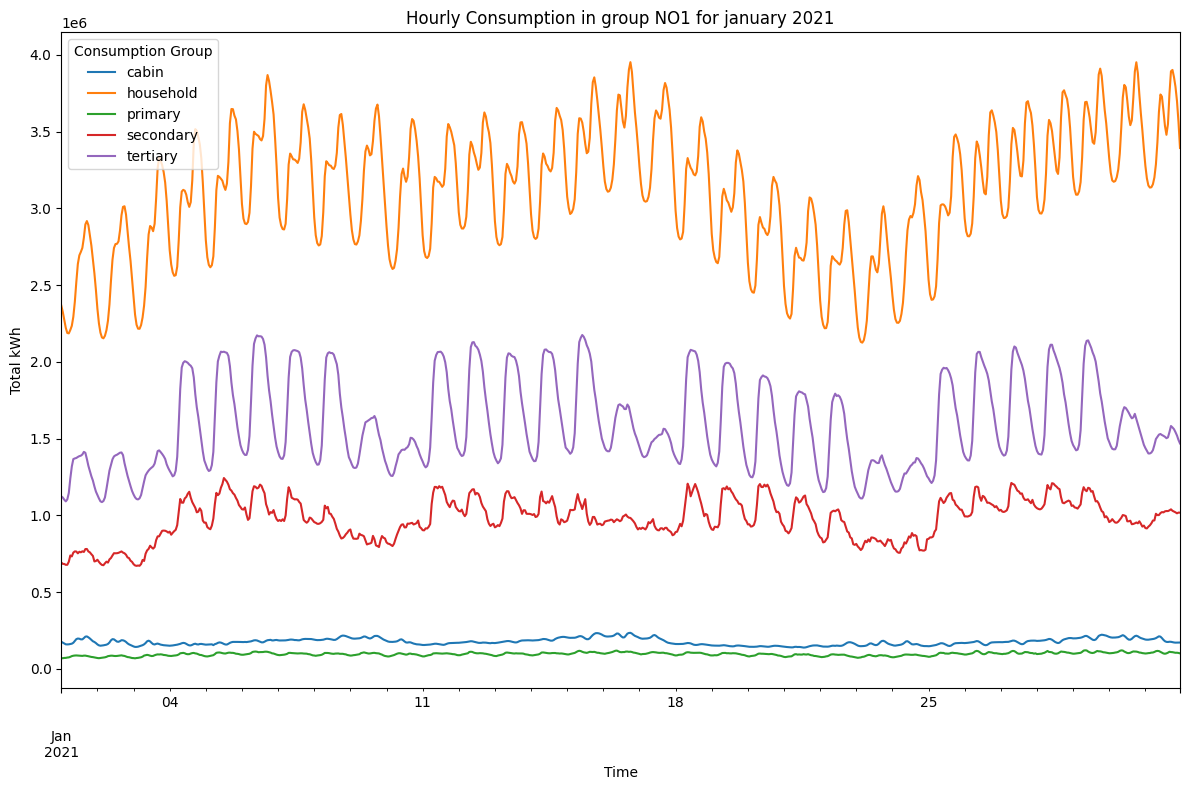

In [32]:
# Extract the data for january
first_month_df = (
    df.filter((F.col("pricearea") == "NO1") &
              (F.month("starttime") == 1))
    .groupBy("starttime", "consumptiongroup")
    .agg(F.sum("quantitykwh").alias("total_quantitykwh"))
    .orderBy("starttime")
)

# Convert dataframe to pandas
first_month_pd = first_month_df.toPandas()

# Convert timestamps for plotting
first_month_pd["starttime"] = pd.to_datetime(first_month_pd["starttime"])

# Pivot so each group becomes a line (column)
pivot_df = first_month_pd.pivot(index="starttime",
    columns="consumptiongroup",
    values="total_quantitykwh")

# Plot
plt.figure(figsize=(12, 8))
pivot_df.plot(ax=plt.gca())

plt.title(f"Hourly Consumption in group NO1 for january {YEAR}")
plt.xlabel("Time")
plt.ylabel("Total kWh")
plt.legend(title="Consumption Group")
plt.tight_layout()
plt.show()


### Insert data into MongoDB

In [38]:
# Read entire cassandra database
cassandra_df = (
    spark.read
    .format("org.apache.spark.sql.cassandra")
    .option("keyspace", KEYSPACE)
    .option("table", TABLE)
    .load()
)

# Convert the cassandra dataframe to pandas
cassandra_pd = cassandra_df.toPandas()

# Impporting my uri from a secret file
from secret import *
# Connect to MongoDB
client = MongoClient(uri)

# Choose target database and collection
mongo_db = client["elhub_data"]
mongo_collection = mongo_db[f"consumption_{YEAR}"]

# Convert timestamps to native Python datetime (for BSON)
for col in ["starttime", "endtime", "lastupdatedtime"]:
    if col in cassandra_pd.columns:
        cassandra_pd[col] = pd.to_datetime(cassandra_pd[col]).dt.to_pydatetime()

# Convert DataFrame to list of dictionaries
records_to_insert = cassandra_pd.to_dict("records")

# Clear old data to avoid duplicates for bettr development
mongo_collection.delete_many({})

# Insert all records
if records_to_insert:
    mongo_collection.insert_many(records_to_insert)

# Verify insertion
for doc in mongo_collection.find().limit(3):
    print(doc)


/var/folders/pf/pxv_xl591dd4_q71x2jsd8x40000gn/T/ipykernel_72714/2363054622.py:24: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  cassandra_pd[col] = pd.to_datetime(cassandra_pd[col]).dt.to_pydatetime()
/var/folders/pf/pxv_xl591dd4_q71x2jsd8x40000gn/T/ipykernel_72714/2363054622.py:24: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  cassandra_pd[col] = pd.to_datetime(cassandra_pd[col]).dt.to_pydatetime()
/var/folders/pf/pxv_xl591dd4_q71x2jsd8x40000gn/T/ipykernel_72714/2363054622.py:24: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a S

{'_id': ObjectId('68fbb353d0576c7012dee154'), 'pricearea': 'NO3', 'consumptiongroup': 'household', 'starttime': datetime.datetime(2021, 1, 1, 0, 0), 'endtime': datetime.datetime(2021, 1, 1, 1, 0), 'lastupdatedtime': datetime.datetime(2024, 12, 20, 10, 35, 40), 'meteringpointcount': 383156, 'quantitykwh': 901666.44}
{'_id': ObjectId('68fbb353d0576c7012dee155'), 'pricearea': 'NO3', 'consumptiongroup': 'household', 'starttime': datetime.datetime(2021, 1, 1, 1, 0), 'endtime': datetime.datetime(2021, 1, 1, 2, 0), 'lastupdatedtime': datetime.datetime(2024, 12, 20, 10, 35, 40), 'meteringpointcount': 383156, 'quantitykwh': 893092.7}
{'_id': ObjectId('68fbb353d0576c7012dee156'), 'pricearea': 'NO3', 'consumptiongroup': 'household', 'starttime': datetime.datetime(2021, 1, 1, 2, 0), 'endtime': datetime.datetime(2021, 1, 1, 3, 0), 'lastupdatedtime': datetime.datetime(2024, 12, 20, 10, 35, 40), 'meteringpointcount': 383156, 'quantitykwh': 869923.4}
